In [1]:
%load_ext autoreload
%autoreload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from scipy import stats

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from MLP.mlp_regression import mlp_regression, model_validation, mlp_prediction, mlp_prediction_error, mlp_train_graph, errorDist, mlp_train_multi_graph, mlp_train_multi_graph_comb, mlp_train_multi_3dgraph_comb
from MLP.utils import combineArray, multiArraySort, data_loader_from_csv, data_loader_pathloss, describeData, data_loader_pathloss_with_freq
from GMM.utils import gp_train_multi_3dgraph, gp_ann_train_multi_3dgraph, gpCompareDiffDim, mergeSet

pd.set_option('display.max_rows', 999)
pd.set_option('precision', 5)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
%autoreload
X_train_m_400, X_val_m_400, y_train_m_400, y_val_m_400, X_train_s_400, X_val_s_400, y_train_s_400, y_val_s_400 = data_loader_from_csv('data/PLdata_paju_wt_400.csv', np.log10(400), 'dist' ,4, testRatio=0.8)
X_train_m_1399, X_val_m_1399, y_train_m_1399, y_val_m_1399, X_train_s_1399, X_val_s_1399, y_train_s_1399, y_val_s_1399 = data_loader_from_csv('data/PLdata_paju_wt_1399.csv', np.log10(1399),'dist', 4, testRatio=0.8)
X_train_m_2249, X_val_m_2249, y_train_m_2249, y_val_m_2249, X_train_s_2249, X_val_s_2249, y_train_s_2249, y_val_s_2249 = data_loader_from_csv('data/PLdata_paju_wt_2249.csv', np.log10(2249),'dist', 4, testRatio=0.8)

X_train_m = combineArray(X_train_m_400, X_train_m_1399, X_train_m_2249)
y_train_m = combineArray(y_train_m_400, y_train_m_1399, y_train_m_2249)
X_val_m = combineArray(X_val_m_400, X_val_m_1399, X_val_m_2249)
y_val_m = combineArray(y_val_m_400, y_val_m_1399, y_val_m_2249)

X_train_s = combineArray(X_train_s_400, X_train_s_1399, X_train_s_2249)
y_train_s = combineArray(y_train_s_400, y_train_s_1399, y_train_s_2249)
X_val_s = combineArray(X_val_s_400, X_val_s_1399, X_val_s_2249)
y_val_s = combineArray(y_val_s_400, y_val_s_1399, y_val_s_2249)

dataX_m = list()
dataY_m = list()
dataX_m.append(X_train_m_400)
dataY_m.append(y_train_m_400)
dataX_m.append(X_train_m_1399)
dataY_m.append(y_train_m_1399)
dataX_m.append(X_train_m_2249)
dataY_m.append(y_train_m_2249)

X_train_m_400

original: 110440
filtered: 24251
Covariance Matrix
           dist      ploss   height
dist    0.87491    4.63464  0.00173
ploss   4.63464  147.96141  0.00553
height  0.00173    0.00553  0.00213
--------------------------------------------------
Preprocessing <data/PLdata_paju_wt_400.csv>...Total 24251
- moving type: total: 18536 (training: 3707/validation: 14829)
- stationary type: total: 5715 (training: 1143/validation: 4572)
original: 110358
filtered: 24209
Covariance Matrix
           dist      ploss   height
dist    0.87318    4.63990  0.00176
ploss   4.63990  184.48977 -0.00469
height  0.00176   -0.00469  0.00213
--------------------------------------------------
Preprocessing <data/PLdata_paju_wt_1399.csv>...Total 24209
- moving type: total: 18494 (training: 3698/validation: 14796)
- stationary type: total: 5715 (training: 1143/validation: 4572)
original: 110246
filtered: 24151
Covariance Matrix
           dist      ploss   height
dist    0.87039    4.67475  0.00176
ploss   4.67

array([[2.40106434, 2.60205999],
       [2.40237583, 2.60205999],
       [2.40271642, 2.60205999],
       ...,
       [3.60164323, 2.60205999],
       [3.60181418, 2.60205999],
       [3.60203836, 2.60205999]])

In [ ]:
X = X_train_m
y = y_train_m

# Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
#    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp_ma = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp_ma.fit(X, y)

filename = 'model/gp_paju_wt_3d_model.sav'
pickle.dump(gp_ma, open(filename, 'wb'))

<Paju - Winter> Gaussian Process (dist<=4000m)


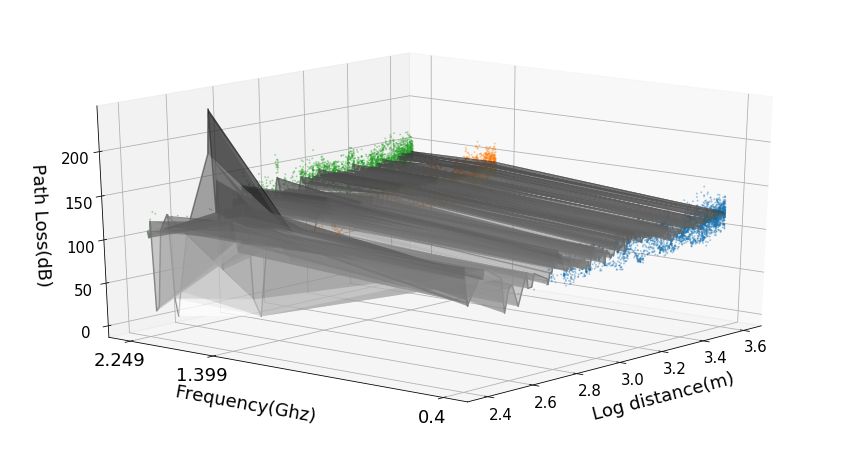

TEST ERROR(dB),RMSE,MAE,MAPE,MSLE,R2
0.4Ghz,10.15969,7.53880,6.82569,0.00864,-1.29513
1.399Ghz,11.85509,8.73572,8.10707,0.01206,-0.91515
2.249Ghz,11.88700,8.65271,7.25145,0.01064,-1.07735
Overall,11.32793,8.30814,7.39447,0.01045,0.04752


In [5]:
%autoreload
model = None
model = pickle.load(open('model/gp_paju_wt_3d_model.sav', 'rb'))

print("<Paju - Winter> Gaussian Process (dist<=4000m)")
mlp_train_multi_3dgraph_comb(model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'])

y_pred_400 = model.predict(X_val_m_400)
y_pred_1399 = model.predict(X_val_m_1399)
y_pred_2249 = model.predict(X_val_m_2249)
y_pred = model.predict(X_val_m)
stat = np.array([mlp_prediction_error(model,X_val_m_400, y_val_m_400),mean_absolute_error(y_pred_400, y_val_m_400),mean_absolute_percentage_error(y_pred_400, y_val_m_400),mean_squared_log_error(y_val_m_400, np.abs(y_pred_400)),r2_score(y_pred_400, y_val_m_400),
                 mlp_prediction_error(model,X_val_m_1399, y_val_m_1399),mean_absolute_error(y_pred_1399, y_val_m_1399),mean_absolute_percentage_error(y_pred_1399, y_val_m_1399),mean_squared_log_error(y_val_m_1399,np.abs(y_pred_1399)),r2_score(y_pred_1399, y_val_m_1399),
                 mlp_prediction_error(model,X_val_m_2249, y_val_m_2249),mean_absolute_error(y_pred_2249, y_val_m_2249),mean_absolute_percentage_error(y_pred_2249, y_val_m_2249),mean_squared_log_error(y_val_m_2249,np.abs(y_pred_2249)),r2_score(y_pred_2249, y_val_m_2249),
                 mlp_prediction_error(model,X_val_m, y_val_m), mean_absolute_error(y_pred, y_val_m),mean_absolute_percentage_error(y_pred, y_val_m),mean_squared_log_error(y_val_m,np.abs(y_pred)),r2_score(y_pred, y_val_m)])

(pd.DataFrame(stat.reshape((4,5)),index=pd.Index(['0.4Ghz','1.399Ghz','2.249Ghz', 'Overall']), columns=pd.Index(['RMSE','MAE','MAPE','MSLE','R2'],name='TEST ERROR(dB)')))